In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns
from PIL import Image
import os
import cv2

In [2]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
def load_and_preprocess_images(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img_resized = cv2.resize(img, target_size)
            images.append(img_resized)
    return images

In [4]:
def process_images_in_batches(folder, batch_size=32):
    processed_data = []
    for i in range(0, len(os.listdir(folder)), batch_size):
        batch_files = os.listdir(folder)[i:i+batch_size]
        batch_images = [cv2.imread(os.path.join(folder, file)) for file in batch_files if os.path.isfile(os.path.join(folder, file))]
        # Preprocess this batch of images (e.g., normalization, resizing)
        batch_preprocessed = [cv2.resize(img, (224, 224)) / 255.0 for img in batch_images if img is not None]
        processed_data.extend(batch_preprocessed)
        # Free up memory after processing
        del batch_images
        del batch_preprocessed
    return np.array(processed_data)

In [5]:
# Paths to image directories
X_train_dir = '/kaggle/input/pancreas-cancer-dataset/Dataset/X_train'
Y_train_dir = '/kaggle/input/pancreas-cancer-dataset/Dataset/Y_train'
X_test_dir = '/kaggle/input/pancreas-cancer-dataset/Dataset/X_test'
Y_test_dir = '/kaggle/input/pancreas-cancer-dataset/Dataset/Y_test'

In [6]:
# Load and preprocess smaller-sized images directly
X_train_resized = load_and_preprocess_images(X_train_dir, target_size=(128, 128))

In [7]:
Y_train_resized = load_and_preprocess_images(Y_train_dir, target_size=(128, 128))

In [8]:
X_test_resized = load_and_preprocess_images(X_test_dir, target_size=(128, 128))

In [9]:
Y_test_resized = load_and_preprocess_images(Y_test_dir, target_size=(128, 128))

In [10]:
X_train_resized = np.array(X_train_resized)
Y_train_resized = np.array(Y_train_resized)
X_test_resized= np.array(X_test_resized)
Y_test_resized= np.array(Y_test_resized)

In [11]:
print('X_train_resized shape:', X_train_resized.shape)
print('Y_train_resized shape:', Y_train_resized.shape)
print('X_test_resized shape:', X_test_resized.shape)
print('Y_test_resized shape:', Y_test_resized.shape)

X_train_resized shape: (19287, 128, 128, 3)
Y_train_resized shape: (19287, 128, 128, 3)
X_test_resized shape: (3894, 128, 128, 3)
Y_test_resized shape: (3894, 128, 128, 3)


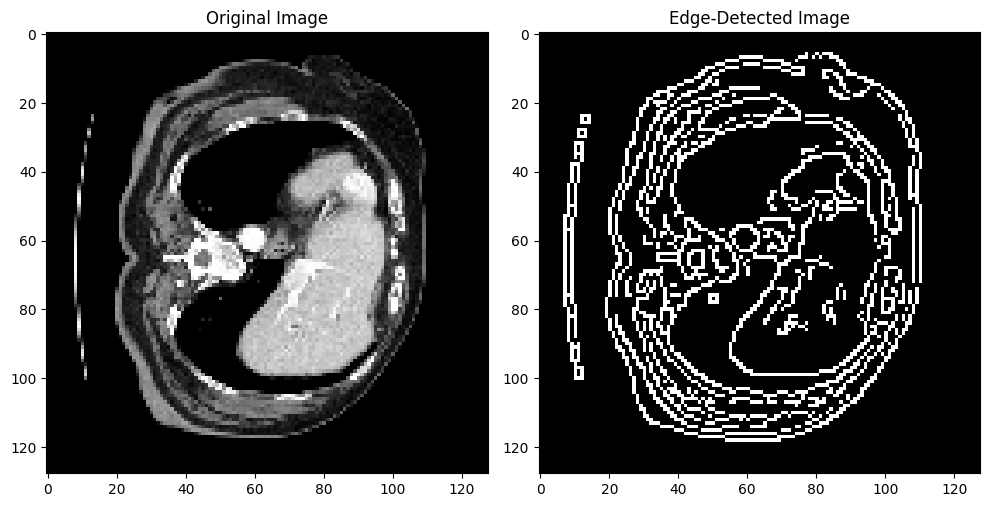

In [12]:
import matplotlib.pyplot as plt

# Choose an image from your preprocessed dataset for visualization
sample_image = X_train_resized[0]

# Apply Canny edge detection
edges = cv2.Canny(sample_image, 100, 200)

# Display the original and edge-detected images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Edge-Detected Image')

plt.tight_layout()
plt.show()

In [13]:
# Convert multi-channel label arrays to binary format
def convert_to_binary(labels):
    binary_labels = np.zeros((labels.shape[0], 1))
    for i in range(labels.shape[0]):
        if np.any(labels[i] > 0):  # Check if any value in the label array is above zero
            binary_labels[i] = 1    # Set as class 1 (cancerous feature) if any value is above zero
    return binary_labels

# Convert training and testing labels to binary format
Y_train_binary = convert_to_binary(Y_train_resized)
Y_test_binary = convert_to_binary(Y_test_resized)

In [14]:
# QRNN Layer Definition
class QRNNLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, dropout=0.5):
        super(QRNNLayer, self).__init__()
        self.hidden_dim = hidden_dim

        self.conv_z = nn.Conv1d(input_dim, hidden_dim, kernel_size, padding=kernel_size-1)
        self.conv_f = nn.Conv1d(input_dim, hidden_dim, kernel_size, padding=kernel_size-1)
        self.conv_o = nn.Conv1d(input_dim, hidden_dim, kernel_size, padding=kernel_size-1)

        self.dropout = nn.Dropout(dropout)
        self.hidden = None

    def forward(self, x):
        batch_size, time_steps, _ = x.size()
        if self.hidden is None or self.hidden.size(0) != batch_size:
            self.hidden = torch.zeros(batch_size, self.hidden_dim).to(x.device)

        x = x.permute(0, 2, 1)  # Shape (batch_size, input_dim, time_steps)
        z = self.conv_z(x)[:, :, :-self.conv_z.padding[0]]
        f = torch.sigmoid(self.conv_f(x)[:, :, :-self.conv_f.padding[0]])
        o = torch.sigmoid(self.conv_o(x)[:, :, :-self.conv_o.padding[0]])
        f = self.dropout(f)

        z = z.permute(0, 2, 1)  # Shape (batch_size, time_steps, hidden_dim)
        f = f.permute(0, 2, 1)
        o = o.permute(0, 2, 1)

        h = []
        for t in range(z.size(1)):
            self.hidden = f[:, t, :] * self.hidden + (1 - f[:, t, :]) * z[:, t, :]
            h_t = o[:, t, :] * self.hidden
            h.append(h_t.unsqueeze(1))

        h = torch.cat(h, dim=1)
        return h

    def reset_hidden_state(self):
        self.hidden = None

In [15]:
# QRNN Model Definition
class QRNNModel(nn.Module):
    def __init__(self):
        super(QRNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.qrnn1 = QRNNLayer(256, 256, kernel_size=2)
        self.qrnn2 = QRNNLayer(256, 256, kernel_size=2)
        self.qrnn3 = QRNNLayer(256, 256, kernel_size=2)
        self.fc = nn.Linear(256, 1)

    def forward(self, x):
        x = self.features(x)  # x should have shape [batch_size, 256, height, width]
        x = x.view(x.size(0), x.size(1), -1).permute(0, 2, 1)  # Reshape x to [batch_size, height*width, 256]
        self.qrnn1.reset_hidden_state()  # Reset hidden state before forward pass
        self.qrnn2.reset_hidden_state()  # Reset hidden state before forward pass
        self.qrnn3.reset_hidden_state()  # Reset hidden state before forward pass
        x = self.qrnn1(x)  # Output from QRNN should be [batch_size, height*width, 256]
        x = self.qrnn2(x)
        x = self.qrnn3(x)
        x = x.mean(dim=1)  # Global average pooling over the time dimension
        x = self.fc(x)  # x should have shape [batch_size, num_classes]
        return x

In [16]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [17]:
# Model, Criterion, Optimizer
model = QRNNModel().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
# Convert the numpy arrays to PyTorch tensors and adjust dimensions
X_train_resized = torch.tensor(X_train_resized, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to NCHW format
Y_train_binary = torch.tensor(Y_train_binary, dtype=torch.float32)  # Ensure labels are float32 for BCEWithLogitsLoss
X_test_resized = torch.tensor(X_test_resized, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to NCHW format
Y_test_binary = torch.tensor(Y_test_binary, dtype=torch.float32)  # Ensure labels are float32 for BCEWithLogitsLoss


In [19]:
print(X_train_resized.shape)
print(Y_train_binary.shape)
print(X_test_resized.shape)
print(Y_test_binary.shape)

torch.Size([19287, 3, 128, 128])
torch.Size([19287, 1])
torch.Size([3894, 3, 128, 128])
torch.Size([3894, 1])


In [20]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Combine the features and labels into a TensorDataset
train_dataset = TensorDataset(X_train_resized, Y_train_binary)
val_dataset = TensorDataset(X_test_resized, Y_test_binary)

# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [21]:
# Training Loop
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/10, Train Loss: 2.9323, Train Acc: 0.6176, Val Loss: 0.6316, Val Acc: 0.6608
Epoch 2/10, Train Loss: 2.1510, Train Acc: 0.6339, Val Loss: 0.6354, Val Acc: 0.6608
Epoch 3/10, Train Loss: 1.3732, Train Acc: 0.6506, Val Loss: 0.5499, Val Acc: 0.6929
Epoch 4/10, Train Loss: 0.7206, Train Acc: 0.6849, Val Loss: 0.4980, Val Acc: 0.7278
Epoch 5/10, Train Loss: 0.6279, Train Acc: 0.7123, Val Loss: 0.4889, Val Acc: 0.7386
Epoch 6/10, Train Loss: 0.5597, Train Acc: 0.7341, Val Loss: 0.4686, Val Acc: 0.7540
Epoch 7/10, Train Loss: 0.5671, Train Acc: 0.7556, Val Loss: 0.4579, Val Acc: 0.7635
Epoch 8/10, Train Loss: 0.6363, Train Acc: 0.7590, Val Loss: 0.4067, Val Acc: 0.7976
Epoch 9/10, Train Loss: 0.4180, Train Acc: 0.8048, Val Loss: 0.3603, Val Acc: 0.8349
Epoch 10/10, Train Loss: 0.3759, Train Acc: 0.8327, Val Loss: 0.3441, Val Acc: 0.8462


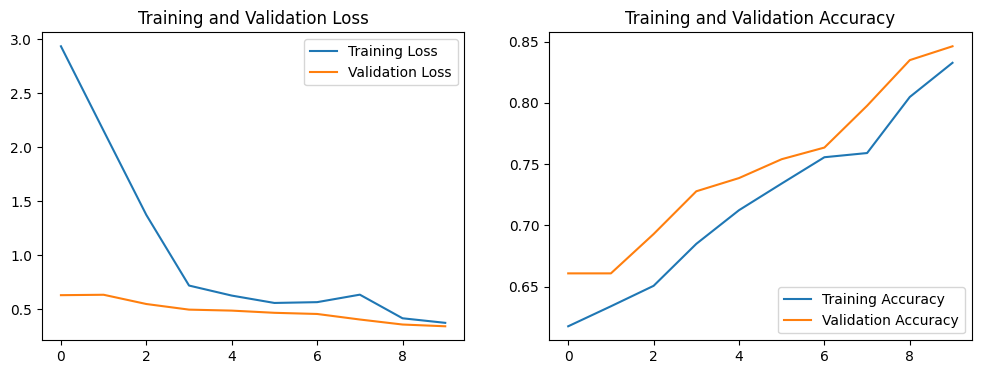

In [22]:
# Plotting Loss and Accuracy
epochs_range = range(num_epochs)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

The predicted class is non-cancerous with a confidence of 0.67


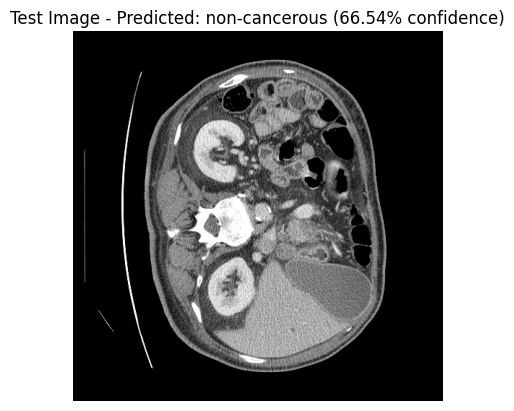

In [23]:
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load and preprocess the test image
test_image_path = '/kaggle/input/pancreas-cancer-dataset/Dataset/X_test/1006.png'  # Adjust the path accordingly
test_image = Image.open(test_image_path).convert('RGB')

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to the model's input size
    transforms.ToTensor(),          # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

# Apply transformations to the image
test_image_tensor = transform(test_image).unsqueeze(0)  # Add batch dimension

# Perform the prediction
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    prediction = model(test_image_tensor.to(device))

# Convert prediction to class label (0: non-cancerous, 1: cancerous)
class_label = 'cancerous' if torch.sigmoid(prediction) > 0.5 else 'non-cancerous'
confidence = torch.sigmoid(prediction).item() if torch.sigmoid(prediction) > 0.5 else 1 - torch.sigmoid(prediction).item()

print(f'The predicted class is {class_label} with a confidence of {confidence:.2f}')

# Visualize the input image
plt.imshow(test_image)
plt.title(f'Test Image - Predicted: {class_label} ({confidence:.2%} confidence)')
plt.axis('off')
plt.show()


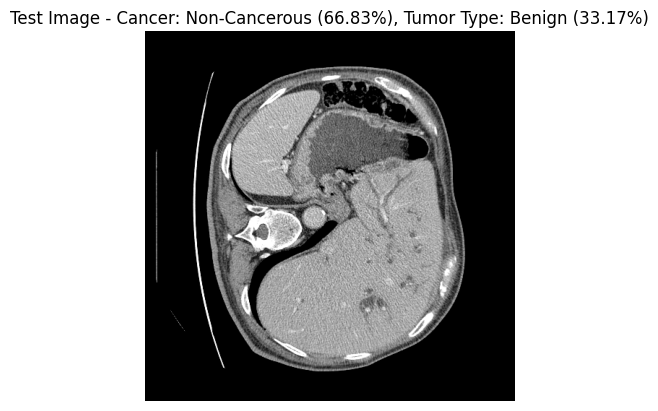

Cancer Prediction - Class: Non-Cancerous, Confidence: 66.83%
Tumor Type Prediction - Class: Benign, Confidence: 33.17%


In [24]:
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load and preprocess the test image
test_image_path = '/kaggle/input/pancreas-cancer-dataset/Dataset/X_test/1035.png'  # Adjust the path accordingly
test_image = Image.open(test_image_path).convert('RGB')

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to the model's input size
    transforms.ToTensor(),          # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

# Apply transformations to the image
test_image_tensor = transform(test_image).unsqueeze(0)  # Add batch dimension

# Perform the prediction
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    cancer_prediction = model(test_image_tensor.to(device))

# Convert prediction to class label (0: non-cancerous, 1: cancerous)
cancer_class_label = 'Cancerous' if torch.sigmoid(cancer_prediction) > 0.5 else 'Non-Cancerous'
cancer_confidence = torch.sigmoid(cancer_prediction).item() if torch.sigmoid(cancer_prediction) > 0.5 else 1 - torch.sigmoid(cancer_prediction).item()

# Perform other predictions (assuming model outputs another prediction for tumor type)
# Modify this part based on your model's actual architecture if it has multiple outputs
with torch.no_grad():
    tumor_type_prediction = model(test_image_tensor.to(device))  # Replace with actual tumor type output layer if different

tumor_type_label = 'Benign' if torch.sigmoid(tumor_type_prediction) < 0.5 else 'Malignant'
tumor_type_confidence = torch.sigmoid(tumor_type_prediction).item() if torch.sigmoid(tumor_type_prediction) < 0.5 else 1 - torch.sigmoid(tumor_type_prediction).item()

# Visualize the input image
plt.imshow(test_image)
plt.title(f'Test Image - Cancer: {cancer_class_label} ({cancer_confidence:.2%}), Tumor Type: {tumor_type_label} ({tumor_type_confidence:.2%})')
plt.axis('off')
plt.show()

# Print predictions
print(f'Cancer Prediction - Class: {cancer_class_label}, Confidence: {cancer_confidence:.2%}')
print(f'Tumor Type Prediction - Class: {tumor_type_label}, Confidence: {tumor_type_confidence:.2%}')
